# Obtaining High Performance Areas (C3 model)

## Imports

In [3]:
from cobra.io import read_sbml_model
from cobra import flux_analysis
import random
import time
from cobra.flux_analysis import flux_variability_analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Reading and preparing the model

In [4]:
"""
Read and prepare c3 model
"""

c3_model = read_sbml_model("c3_model.xml")

c3_model.solver = "glpk"

c3_model.objective = "Arabidopsis_biomass_tx"

#Setting up Rubisco carboxylase/oxygenase ratio in C3 model
Rubisco_carboxylase = c3_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p")
Rubisco_oxygenase = c3_model.reactions.get_by_id("RXN_961_p")
const = c3_model.problem.Constraint(3 * Rubisco_oxygenase.flux_expression - Rubisco_carboxylase.flux_expression , lb = 0, ub = 0)
c3_model.add_cons_vars(const)


#Setting up Light dependent maintenace in the C3 model
def c3_maintenance(c3_model):
    c3_model.reactions.ATPase_tx.flux_expression
    c3_model.reactions.Photon_tx.flux_expression

    const = c3_model.problem.Constraint((0.0049 * c3_model.reactions.Photon_tx.flux_expression + 2.7852) - c3_model.reactions.ATPase_tx.flux_expression , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

    const = c3_model.problem.Constraint(c3_model.reactions.ATPase_tx.flux_expression - 3 *(c3_model.reactions.NADPHoxc_tx.flux_expression + c3_model.reactions.NADPHoxp_tx.flux_expression + c3_model.reactions.NADPHoxm_tx.flux_expression) , lb = 0, ub = 0)
    c3_model.add_cons_vars(const)

c3_maintenance(c3_model)

## Performing pFBA

### Determination of biomass flux and absolute sum of fluxes for each of the 9 starting points

In [5]:
"""
Functions to perform the simulation
"""

def c3_simulation(light, N, c3_model):
    with c3_model:
        #Bounds for light
        c3_model.reactions.Photon_tx.lower_bound = 0
        c3_model.reactions.Photon_tx.upper_bound = light
        #Bounds for Nitrogen
        c3_model.reactions.Nitrate_tx.lower_bound = 0
        c3_model.reactions.Nitrate_tx.upper_bound = N
        #pFBA
        solution = flux_analysis.pfba(c3_model)
        sum_of_flux = solution.fluxes.abs().sum()
        solution_frame=solution.to_frame()
        growth = solution_frame.loc["Arabidopsis_biomass_tx"]["fluxes"]
        return (sum_of_flux, growth)

In [6]:
"""
Build Dictionary with the combination of Light/Nitrogen conditions as a key,
 and Biomass flux and Sum of fluxes as values
"""

#Grid of light and Nitrogen conditions to use
light_uptake = [100, 250, 500]
nitrogen_uptake = [0.2, 2.5, 6]

#Dictionaries to hold the results
res_c3 = {}


#Perform the simulations for diferent combinations of Light/N and store them in the dictionary
for l in light_uptake:
    for n in nitrogen_uptake:
        res_c3[(l,n)] = c3_simulation(l,n,c3_model)

print(res_c3)




{(100, 0.2): (144.10493789253468, 0.0021314433194739766), (100, 2.5): (591.793640245098, 0.011350384834413843), (100, 6): (591.793640245098, 0.011350384834413843), (250, 0.2): (144.10493789253405, 0.0021314433194739627), (250, 2.5): (1336.7397177187358, 0.026643041493424568), (250, 6): (1467.1946503807058, 0.029318769113680185), (500, 0.2): (144.10493789253405, 0.0021314433194739627), (500, 2.5): (1336.7397177187358, 0.026643041493424568), (500, 6): (2929.300233939115, 0.059266076245790986)}


## Computation of the High Performance Areas

In order to compute the high performance area for a starting point a technique involving random sampling was devised in order to map out this area. Firstly, flux balance analysis (FVA) was used to estimate the range of possible nitrogen and light uptake values, with the FVA constrained to have at least a sum of fluxes equal to the absolute sum of fluxes of the starting point. This will save us a lot of computation time, by defining a priori the bounds in which random values for nitrogen and light uptake should be generated.
Then, a new pFBA simulation will be performed with the constrains that the biomass value must be at least 80% of the one obtained with the initial pFBA simulation for the starting point, and the sum of fluxes value cannot surpass the one determined for the starting point. 
By defining the high performance areas as the range of feasible solutions for the model under the aforementioned constrains for different light and nitrogen uptakes, one of the most logical courses of action in order to map them out would be to perform a lot of simulations with different light and nitrogen uptakes, and store feasible solutions. That is exactly what the code described below performs.
The function will receive the feasible range of uptakes of nitrogen and light from the FVA and use them in functions from the random module of python, which will generate random numbers within those constrains. These values will then be used as a forced flux value for the nitrogen and light uptakes of the simulation. Unfeasible solutions will be ignored, and the algorithm will stop once 500 feasible solutions have been reached.

In [7]:
"""
Function to perform the FVA at 80% fraction of optimum, restraining the sum of fluxes to be at maximum equal 
to the sum of fluxes of the initial point
"""

def fva_c3(sum_of_flux, c3_model):
    with c3_model:
        if sum_of_flux != None:
        #Sum of flux constrain
            coefficients = dict()
            for rxn in c3_model.reactions:
                coefficients[rxn.forward_variable] = 1.
                coefficients[rxn.reverse_variable] = 1.
            constraint = c3_model.problem.Constraint(0, lb=0, ub=sum_of_flux)

            c3_model.add_cons_vars(constraint)
            c3_model.solver.update()
            constraint.set_linear_coefficients(coefficients=coefficients)

        #FVA
        solution = flux_variability_analysis(c3_model, reaction_list=["Nitrate_tx","Photon_tx"], fraction_of_optimum=0.8)
        return solution


In [8]:
"""
Function to perform the sampling using random points in a uniform distribution
"""

def random_simul_c3(light_lb, light_ub, nitrogen_lb, nitrogen_ub, sum_of_flux, biomass, c3_model):
    with c3_model:
        if sum_of_flux is not None:
        #Sum of flux constrain
            coefficients = dict()
            for rxn in c3_model.reactions:
                coefficients[rxn.forward_variable] = 1.
                coefficients[rxn.reverse_variable] = 1.
            constraint = c3_model.problem.Constraint(0, lb=0, ub=sum_of_flux)

            c3_model.add_cons_vars(constraint)
            c3_model.solver.update()
            constraint.set_linear_coefficients(coefficients=coefficients)

        #Bounds for Biomass
        c3_model.reactions.Arabidopsis_biomass_tx.lower_bound = biomass * 0.8
        c3_model.reactions.Arabidopsis_biomass_tx.upper_bound = 9999

        #Bounds for light
        random_light = random.uniform(light_lb, light_ub)
        c3_model.reactions.Photon_tx.lower_bound = random_light
        c3_model.reactions.Photon_tx.upper_bound = random_light

        #Bounds for N
        random_nitrogen = random.uniform(nitrogen_lb, nitrogen_ub)
        c3_model.reactions.Nitrate_tx.lower_bound = random_nitrogen
        c3_model.reactions.Nitrate_tx.upper_bound = random_nitrogen

        #pFBA
        try:
            solution = flux_analysis.pfba(c3_model)
            solution_frame=solution.to_frame()
            growth = solution_frame.loc["Arabidopsis_biomass_tx"]["fluxes"]
            nitrogen_uptake = solution_frame.loc["Nitrate_tx"]["fluxes"]
            light_uptake = solution_frame.loc["Photon_tx"]["fluxes"]
            sum_of_fluxes= solution.fluxes.abs().sum()
            return light_uptake, nitrogen_uptake, growth, sum_of_fluxes
        except:
            pass

In [9]:
"""Example of FVA results"""
res = fva_c3(sum_of_flux =  res_c3[(500,6)][0], c3_model=c3_model)
res

,minimum,maximum
Nitrate_tx,4.448897,5.902167
Photon_tx,401.049407,543.953046


In [10]:
"""
Perform the sampling
"""

#Reproducibility
random.seed(123)

#Lists to store the results

res_list_n = []
res_list_light = []
res_list_biomass = []
res_list_sof = []

#Termination condition
i = True

test = res_c3[(250,6)] #Defining the stating point (still manual)

#Just checking simulation time
start = time.time()

#Defining the random simulation bounds using FVA
res = fva_c3(sum_of_flux =  test[0], c3_model=c3_model)
l_lb = res.iloc[1]["minimum"]
l_ub = res.iloc[1]["maximum"]
n_lb = res.iloc[0]["minimum"]
n_ub = res.iloc[0]["maximum"]

#Loop to perform the sampling
while i:
    res = random_simul_c3(light_lb=l_lb, light_ub = l_ub , nitrogen_lb = n_lb ,nitrogen_ub = n_ub,sum_of_flux = test[0],biomass = test[1] , c3_model=c3_model)
    if res != None:
        res_list_light.append(res[0])
        res_list_n.append(res[1])
        res_list_biomass.append(res[2])
        res_list_sof.append(res[3])
    if len(res_list_n) == 500: #Defining number of viable solutions until the loop stops (still manual)
        i = False

end = time.time()
print(f"This simulation lasted {(end - start)/60} minutes")
print(f"This simulation lasted {(end - start)} seconds")

This simulation lasted 3.1144975940386455 minutes
This simulation lasted 186.86985564231873 seconds


In [11]:
"""Checking the lists"""
print(res_list_light)
print(res_list_n)
print(res_list_biomass)
print(res_list_sof)

[228.16792526551004, 224.92564713969568, 232.25593236150684, 208.34802735914485, 234.61760870528366, 238.36414274312713, 246.73925100792897, 237.72623561123203, 248.73499644618246, 248.8646498978172, 254.99492656772955, 256.7520735089263, 260.53349419424325, 246.112235238791, 228.12971658979785, 233.69113512413657, 250.04460836436274, 226.44672259929075, 240.14612883669685, 254.75471449999824, 246.76581522201883, 255.27315865467943, 256.56569673621715, 233.31978485656782, 237.86693430473642, 240.06564657583476, 225.37517021142975, 215.14747527619778, 264.7683777844005, 240.714916123355, 267.9619891626776, 236.26237357278086, 252.1044309976411, 236.9040356741857, 209.7986140250132, 223.61739171879887, 259.0926479380854, 230.71458650146897, 228.83270639937973, 241.92994223570318, 225.1675540316505, 231.67255263177194, 239.3251705630245, 224.35660458359794, 243.80182044572544, 250.2608375648505, 204.15423525435176, 215.2294436661478, 253.73956689892995, 221.25266018179255, 240.03014074270

## Plots

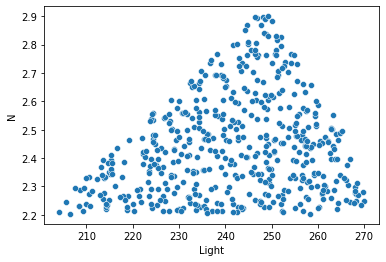

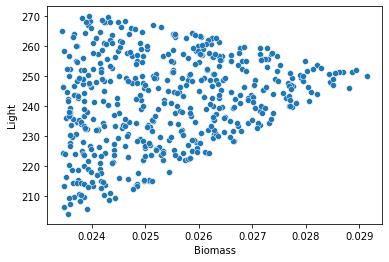

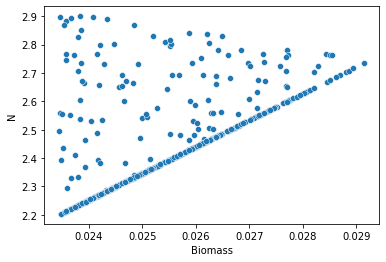

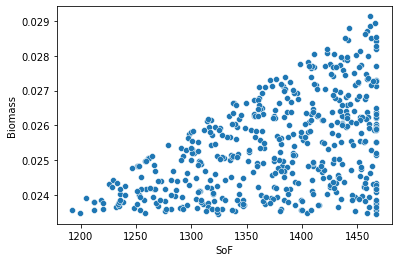

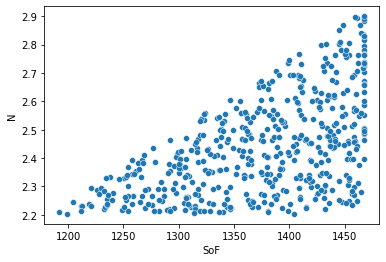

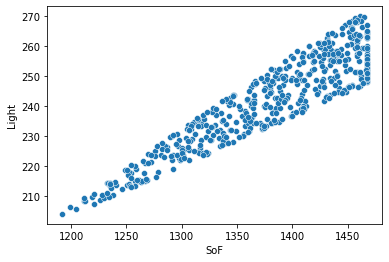

In [12]:
"""Initial Plotting of High Performance Areas"""

df_c3 = pd.DataFrame(list(zip(res_list_light, res_list_n, res_list_biomass, res_list_sof)), columns=["Light", "N", "Biomass", "SoF"])

sns.scatterplot(x='Light', y='N', data=df_c3)
plt.show()
sns.scatterplot(x='Biomass', y='Light', data=df_c3)
plt.show()
sns.scatterplot(x='Biomass', y='N', data=df_c3)
plt.show()
sns.scatterplot(x='SoF', y='Biomass', data=df_c3)
plt.show()
sns.scatterplot(x='SoF', y='N', data=df_c3)
plt.show()
sns.scatterplot(x='SoF', y='Light', data=df_c3)
plt.show()

In [13]:
"""Saving results to a .csv for latter plotting"""

#df_c3.to_csv(f"Sample_{list(res_c3.keys())[5]}_c3.csv", index=True)

'Saving results to a .csv for latter plotting'